### 过拟合：剪枝参数与回归模型调参

| 参数含义 | xgb.train() | xgb.XGBRegressor |
|---|---|---|
| 树的最大深度* | max_depth, 默认6 | max_depth, 默认6 |
| 每次生成树时随机抽样特征的比例* | colsample_bytree, 默认1 | colsample_bytree, 默认1 |
| 每次生成树的一层时<br>随机抽样特征的比例* | colsample_bylevel, 默认1 | colsample_bylevel, 默认1 |
| 每次生成一个叶子节点时<br>随机抽样特征的比例 | colsample_bynode, 默认1 | N.A. |
| 一个叶子节点上所需要的最小h，<br>即子节点处的二阶导数之和<br>类似于样本权重 | min_child_weight, 默认1 | min_child_weight, 默认1 |

通常当我们获得了一个数据集后，我们先使用网格搜索找出比较合适的n_estimators和eta组合，然后使用gamma或者max depth观察模型处于什么样的状态(过拟合还是欠拟合)，最后再决定是否要进行剪枝。通常来说，对于XGB模型，大多数时候都是需要剪枝的。

使用xgb.cv这个类来进行剪枝调参，以调整出一组泛化能力很强的参数。

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as XGB
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
x = data
y = target
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=888)
dtrain = XGB.DMatrix(xtrain, ytrain)
dtest = XGB.DMatrix(xtest, ytest)

下面是在观察默认参数下现有数据集的表现。

In [ ]:
param1 = {'objective':'reg:squarederror'
          , 'subsample':1
          , 'max_depth':6
          , 'eta':0.3
          , 'gamma':0
          , 'lambda':1
          , 'alpha':0
          , 'colsample_bytree':1
          , 'colsample_bylevel':1
          , 'colsample_bynode':1

          }
num_round = 200

In [ ]:
from time import time
import datetime
time0 = time()
cvresult1 = XGB.cv(param1, dtrain, num_round)
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%S:%f'))

00:00:524759


In [ ]:
cvresult1

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7.041780,0.190282,7.457310,0.585668
1,5.350889,0.119375,6.131143,0.670070
2,4.124506,0.076088,5.333468,0.837220
3,3.238460,0.032855,4.800625,0.841329
4,2.586832,0.016378,4.389032,0.732693
...,...,...,...,...
195,0.001066,0.000033,3.760445,0.591509
196,0.001066,0.000033,3.760445,0.591509
197,0.001066,0.000033,3.760445,0.591509
198,0.001066,0.000033,3.760445,0.591509


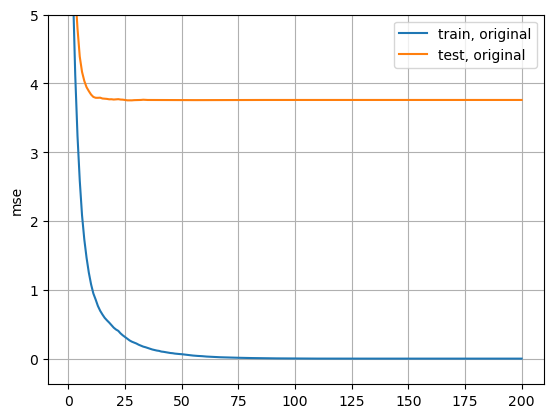

In [ ]:
fig, ax = plt.subplots(1)
ax.grid()
ax.plot(range(1, 201), cvresult1.iloc[:, 0], label = 'train, original')
ax.plot(range(1, 201), cvresult1.iloc[:, 2], label = 'test, original')
ax.legend()
ax.set_ylim(top=5)
ax.set_ylabel('mse')
plt.show()

模型处于过拟合的状态，需要剪枝，以达到训练集和测试集上效果差不多的

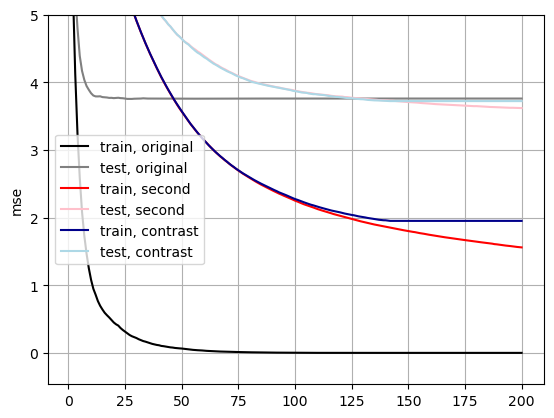

In [ ]:
# 调参 可视化
param2 = {'objective':'reg:squarederror'
          , 'subsample':1
          , 'max_depth':3
          , 'eta':0.03
          , 'gamma':0
          , 'lambda':0.5
          , 'alpha':1
          , 'colsample_bytree':1
          , 'colsample_bylevel':1
          , 'colsample_bynode':1

          }
param3 = {'objective':'reg:squarederror'
          , 'subsample':1
          , 'max_depth':3
          , 'eta':0.03
          , 'gamma':20
          , 'lambda':0.5
          , 'alpha':1
          , 'colsample_bytree':1
          , 'colsample_bylevel':1
          , 'colsample_bynode':1

          }
cvresult2 = XGB.cv(param2, dtrain, num_round)
cvresult3 = XGB.cv(param3, dtrain, num_round)
fig, ax = plt.subplots(1)
ax.grid()

ax.plot(range(1, 201), cvresult1.iloc[:, 0], label='train, original', color='black') # 黑色
ax.plot(range(1, 201), cvresult1.iloc[:, 2], label='test, original', color='gray') # 灰色
ax.plot(range(1, 201), cvresult2.iloc[:, 0], label='train, second', color='red') # 红色
ax.plot(range(1, 201), cvresult2.iloc[:, 2], label='test, second', color='pink') # 粉色
ax.plot(range(1, 201), cvresult3.iloc[:, 0], label='train, contrast', color='darkblue') # 深蓝色
ax.plot(range(1, 201), cvresult3.iloc[:, 2], label='test, contrast', color='lightblue') # 浅蓝色
ax.legend()
ax.set_ylim(top=5)
ax.set_ylabel('mse')
plt.show()

### 使用pickle保存和调用训练好的XGB模型

In [ ]:
import pickle

bst = XGB.train(param2, dtrain, num_round)

In [ ]:
pickle.dump(bst, open('bst.dat', 'wb'))

In [ ]:
import sys

sys.path

关闭现有文件之后尝试导入

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
import pickle
import xgboost as XGB
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
x = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=888)
dtrain = XGB.DMatrix(xtrain, ytrain)
dtest = XGB.DMatrix(xtest)

In [ ]:
# 导入模型
load_model = pickle.load(open('bst.dat', 'rb'))

In [ ]:
y_pred = load_model.predict(dtest)

In [ ]:
MSE(ytest, y_pred)

9.016553348049989

In [ ]:
r2_score(ytest, y_pred)

0.8766999985260078

### 使用joblib保存和调用训练好的xgb模型

In [4]:
import joblib


In [ ]:

joblib.dump(bst, 'xgb.dat')


In [5]:

loaded_model = joblib.load('bst.dat')
y_pred = loaded_model.predict(dtest)

In [6]:
MSE(ytest, y_pred)

9.016553348049989

In [7]:
r2_score(ytest, y_pred)

0.8766999985260078

## 分类时样本不平衡问题

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as XGB
from xgboost import XGBClassifier as XGBC 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as CM, recall_score as Recall, roc_auc_score as AUC

In [10]:
class1 = 500
class2 = 50
centers = [[0.0, 0.0], [2.0, 2.0]]
cluster_std = [1.5, 0.5]
x, y = make_blobs(n_samples=[class1, class2]
                  , n_features=2
                  , centers=centers
                  , cluster_std=cluster_std
                  , random_state=888
                  , shuffle=False)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=888)

In [13]:
(y == 1).sum()/y.shape[0], (y == 0).sum()/y.shape[0]

(0.09090909090909091, 0.9090909090909091)

### 使用sklearn

#### 无视样本不均衡问题

In [ ]:
clf = XGBC().fit(xtrain, ytrain)
y_pred = clf.predict(xtest)
clf.score(xtest, ytest) # 分类模型的Score返回的是Accuracy

0.9393939393939394

In [20]:
CM(ytest, y_pred, labels = [1, 0])# 少数类写在前面

array([[  6,   7],
       [  3, 149]], dtype=int64)

In [21]:
Recall(ytest, y_pred)

0.46153846153846156

In [22]:
AUC(ytest, clf.predict_proba(xtest)[:, 1])

0.9807692307692307

#### scale_pos_weight

负/正样本比例

In [36]:
clf2 = XGBC(scale_pos_weight = 10).fit(xtrain, ytrain)
ypred2 = clf2.predict(xtest)
ypredprob2 = clf2.predict_proba(xtest)
clf2.score(xtest, ytest)

0.9515151515151515

In [37]:
CM(ytest, ypred2, labels=[1, 0])

array([[  9,   4],
       [  4, 148]], dtype=int64)

In [38]:
Recall(ytest, ypred2)

0.6923076923076923

In [39]:
AUC(ytest, ypredprob2[:, 1])

0.9762145748987854

In [41]:
for i in [1, 5, 10, 15, 20, 30, 40, 50]:
    clf = XGBC(scale_pos_weight = i).fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    yprob = clf.predict_proba(xtest)
    print(i)
    print('\tAccuracy:{}'.format(clf.score(xtest, ytest)))
    print('\tRecall:{}'.format(Recall(ytest,ypred)))
    print('\tAUC:{}'.format(AUC(ytest, yprob[:, 1])))

1
	Accuracy:0.9393939393939394
	Recall:0.46153846153846156
	AUC:0.9807692307692307
5
	Accuracy:0.9393939393939394
	Recall:0.6153846153846154
	AUC:0.978744939271255
10
	Accuracy:0.9515151515151515
	Recall:0.6923076923076923
	AUC:0.9762145748987854
15
	Accuracy:0.9393939393939394
	Recall:0.5384615384615384
	AUC:0.9767206477732794
20
	Accuracy:0.9393939393939394
	Recall:0.6153846153846154
	AUC:0.972672064777328
30
	Accuracy:0.9393939393939394
	Recall:0.6153846153846154
	AUC:0.9752024291497974
40
	Accuracy:0.9454545454545454
	Recall:0.6153846153846154
	AUC:0.9762145748987854
50
	Accuracy:0.9515151515151515
	Recall:0.6923076923076923
	AUC:0.9777327935222673


### 使用XGBoost

In [42]:
dtrain = XGB.DMatrix(xtrain, ytrain)
dtest = XGB.DMatrix(xtest, ytest)
param = {'objective':'binary:logistic'
         , 'eta':0.1
         , 'scale_pos_weight':10}
num_round = 100

bst = XGB.train(param, dtrain, num_round)

In [43]:
ypred = bst.predict(dtest)

In [ ]:
ypred.shape, ypred
# 返回的是每一个样本属于正类class1的概率

((165,),
 array([4.6260923e-01, 1.5882446e-01, 1.6393735e-03, 1.7697511e-03,
        2.9718250e-03, 1.0977419e-03, 6.5881020e-01, 1.6393735e-03,
        1.0977419e-03, 1.6393735e-03, 1.0977419e-03, 1.0977419e-03,
        1.6393735e-03, 4.6760261e-02, 1.0977419e-03, 1.0977419e-03,
        1.6393735e-03, 1.0977419e-03, 1.0977419e-03, 1.0977419e-03,
        1.0977419e-03, 1.0977419e-03, 7.0115561e-03, 1.0977419e-03,
        1.0977419e-03, 1.6393735e-03, 5.9641353e-03, 1.6393735e-03,
        1.6393735e-03, 1.0977419e-03, 1.0977419e-03, 1.0977419e-03,
        1.0977419e-03, 5.9641353e-03, 9.6990818e-01, 2.5940866e-03,
        7.2846748e-04, 1.0977419e-03, 5.9641353e-03, 1.6393735e-03,
        1.0977419e-03, 1.6393735e-03, 1.8582023e-03, 9.3463594e-01,
        1.6393735e-03, 1.0977419e-03, 1.0977419e-03, 1.8582023e-03,
        2.2843866e-02, 1.0977419e-03, 2.2843866e-02, 2.2843866e-02,
        3.3997807e-03, 1.0977419e-03, 3.0211234e-03, 2.5940866e-03,
        3.0211234e-03, 8.3037931e-04, 5

In [49]:
# 自己设定阈值

pred = (ypred > 0.5).astype(int)

In [47]:
pred[pred == 1].sum()/pred.shape[0]

0.07878787878787878

In [51]:
scale_pos_weight = [1, 5, 10, 20, 50]
names = ['Majority vs Minority:1'
         , 'Majority vs Minority:5'
         , 'Majority vs Minority:10'
         , 'Majority vs Minority:20'
         , 'Majority vs Minority:50'
         ]
from sklearn.metrics import accuracy_score
for name, i in zip(names, scale_pos_weight):
    param = {'scale_pos_weight':i
             , 'objective':'binary:logistic'
             , 'eta':0.1
             }
    bst = XGB.train(param, dtrain, num_round)
    preds = bst.predict(dtest)
    ypred = (preds > 0.5).astype(int)
    print(name)
    print('\tAccutacy:{}'.format(accuracy_score(ytest, ypred)))
    print('\tRecall:{}'.format(Recall(ytest, ypred)))
    print('\tAUC:{}'.format(AUC(ytest, preds)))

Majority vs Minority:1
	Accutacy:0.9333333333333333
	Recall:0.46153846153846156
	AUC:0.9807692307692308
Majority vs Minority:5
	Accutacy:0.9515151515151515
	Recall:0.6923076923076923
	AUC:0.979251012145749
Majority vs Minority:10
	Accutacy:0.9515151515151515
	Recall:0.6923076923076923
	AUC:0.9777327935222672
Majority vs Minority:20
	Accutacy:0.9454545454545454
	Recall:0.6923076923076923
	AUC:0.9752024291497976
Majority vs Minority:50
	Accutacy:0.9454545454545454
	Recall:0.6923076923076923
	AUC:0.978744939271255


In [52]:
for name, i in zip(names, scale_pos_weight):
    param = {'scale_pos_weight':i
             , 'objective':'binary:logistic'
             , 'eta':0.1
             }
    for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
        bst = XGB.train(param, dtrain, num_round)
        preds = bst.predict(dtest)
        ypred = (preds > threshold).astype(int)
        print('{}, threshold:{}'.format(name, threshold))
        print('\tAccutacy:{}'.format(accuracy_score(ytest, ypred)))
        print('\tRecall:{}'.format(Recall(ytest, ypred)))
        print('\tAUC:{}'.format(AUC(ytest, preds)))

Majority vs Minority:1, threshold:0.1
	Accutacy:0.9636363636363636
	Recall:1.0
	AUC:0.9807692307692308
Majority vs Minority:1, threshold:0.3
	Accutacy:0.9515151515151515
	Recall:0.6923076923076923
	AUC:0.9807692307692308
Majority vs Minority:1, threshold:0.5
	Accutacy:0.9333333333333333
	Recall:0.46153846153846156
	AUC:0.9807692307692308
Majority vs Minority:1, threshold:0.7
	Accutacy:0.9333333333333333
	Recall:0.3076923076923077
	AUC:0.9807692307692308
Majority vs Minority:1, threshold:0.9
	Accutacy:0.9212121212121213
	Recall:0.0
	AUC:0.9807692307692308
Majority vs Minority:5, threshold:0.1
	Accutacy:0.9575757575757575
	Recall:1.0
	AUC:0.979251012145749
Majority vs Minority:5, threshold:0.3
	Accutacy:0.9454545454545454
	Recall:0.6923076923076923
	AUC:0.979251012145749
Majority vs Minority:5, threshold:0.5
	Accutacy:0.9515151515151515
	Recall:0.6923076923076923
	AUC:0.979251012145749
Majority vs Minority:5, threshold:0.7
	Accutacy:0.9515151515151515
	Recall:0.6153846153846154
	AUC:0.97